In [8]:
import matplotlib.pyplot as plt
import subprocess

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append("../")
from utils import createXYPlot
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
df_vax = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/somministrazioni-vaccini-latest.csv")

In [9]:
df_vax.columns

Index(['data', 'forn', 'area', 'eta', 'm', 'f', 'd1', 'd2', 'dpi', 'db1',
       'dbi', 'db2', 'N1', 'N2', 'ISTAT', 'reg'],
      dtype='object')

In [3]:
df_vax

,data,forn,area,eta,m,f,d1,d2,dpi,db1,dbi,db2,N1,N2,ISTAT,reg
0,2020-12-27,Moderna,LAZ,40-49,0,1,1,0,0,0,0,0,ITI,ITI4,12,Lazio
1,2020-12-27,Moderna,SIC,90+,0,1,1,0,0,0,0,0,ITG,ITG1,19,Sicilia
2,2020-12-27,Pfizer/BioNTech,ABR,20-29,1,1,2,0,0,0,0,0,ITF,ITF1,13,Abruzzo
3,2020-12-27,Pfizer/BioNTech,ABR,30-39,1,4,5,0,0,0,0,0,ITF,ITF1,13,Abruzzo
4,2020-12-27,Pfizer/BioNTech,ABR,40-49,1,8,9,0,0,0,0,0,ITF,ITF1,13,Abruzzo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226930,2022-05-23,Pfizer/BioNTech,VEN,50-59,9,8,0,0,0,17,0,0,ITH,ITH3,5,Veneto
226931,2022-05-23,Pfizer/BioNTech,VEN,60-69,11,7,2,2,0,8,6,0,ITH,ITH3,5,Veneto
226932,2022-05-23,Pfizer/BioNTech,VEN,70-79,21,28,0,0,3,17,21,8,ITH,ITH3,5,Veneto
226933,2022-05-23,Pfizer/BioNTech,VEN,80-89,73,83,0,0,0,11,17,128,ITH,ITH3,5,Veneto


In [11]:
fornitori = sorted(df_vax.forn.unique())
anagrafiche = sorted(df_vax.eta.unique())

In [13]:
oggi = np.max(df_vax["data"])
plots_folder = f"./plots/{oggi}/vaccination"
print(plots_folder)
res = subprocess.check_output(f"mkdir -p {plots_folder}",shell=True)

./plots/2022-05-23/vaccination


In [14]:
def group_by_doses(df, keys, columns):
    agg_dict = {c:"sum" for c in columns}
    df = df.groupby(keys).agg(agg_dict).reset_index()
    return df

In [15]:
def get_grid(keys):
    grid = pd.DataFrame()
    for f in keys:
        new_grid = pd.DataFrame(df_vax[f].unique(), columns=[f])
        new_grid['key'] = 0
        grid['key'] = 0
        grid = grid.merge(new_grid, on='key', how='outer')
    grid = grid.sort_values(by=keys).reset_index(drop=True)
    return grid.drop(["key"],axis=1)

In [17]:
def roll_mean(df, key=None):
    df = df.set_index("data")
    col_names = [c for c in df.columns if "dose" in c]
    print(col_names)
    for cname in col_names:
        if key is not None:
            df_roll = pd.DataFrame(df.groupby(key)[cname].rolling(7).mean())
            df_roll = df_roll.rename(columns={cname: f"{cname}_media_7"})
            for k in key:
                df = df.set_index(k, append=True)
            df = df.join(df_roll).reset_index().set_index("data_somministrazione")
        else:
            df[f"{cname}_media_7"] = df[cname].rolling(7).mean()
    
    return df.reset_index()

In [ ]:
df_vax["quarta_dose"] = df_vax["booster_immuno"] + df_vax["d2_booster"]
df_vax["terza_dose"] = df_vax["dose_addizionale_booster"]
df_vax["prima_dose_no_guariti"] = df_vax["prima_dose"]
df_vax["prima_dose"] = df_vax["prima_dose"] + df_vax["pregressa_infezione"]

In [ ]:
cols_to_sum = ["prima_dose", "seconda_dose", "terza_dose", "quarta_dose", "pregressa_infezione", "prima_dose_no_guariti"]
df_vax_yyyy_mm_dd = group_by_doses(df_vax, keys=["data_somministrazione"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fornitore"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica"], columns=cols_to_sum)
df_vax_yyyy_mm_dd_anag_fornitore = group_by_doses(df_vax, keys=["data_somministrazione", "fascia_anagrafica", "fornitore"], columns=cols_to_sum)

In [ ]:
pd.DataFrame(df_vax_yyyy_mm_dd[["prima_dose",
                                "seconda_dose",
                                "terza_dose",
                                "quarta_dose",
                                "pregressa_infezione",
                                "prima_dose_no_guariti"
                               ]].agg(sum),columns=["totale"])

In [ ]:
df_vax_yyyy_mm_dd_pediatrico=df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore=="Pfizer Pediatrico"].drop(columns="fornitore")
df_vax_yyyy_mm_dd = df_vax_yyyy_mm_dd.merge(df_vax_yyyy_mm_dd_pediatrico, on="data_somministrazione", how="left", suffixes=("","_pediatrico"))
for n_dos in ["prima", "seconda", "terza", "quarta"]:
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose"] - df_vax_yyyy_mm_dd[f"{n_dos}_dose_pediatrico"]
    df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"] = df_vax_yyyy_mm_dd[f"{n_dos}_dose_adulti"].combine_first(df_vax_yyyy_mm_dd[f"{n_dos}_dose"])
    
    
    

In [ ]:
df_vax_yyyy_mm_dd = roll_mean(df_vax_yyyy_mm_dd)
df_vax_yyyy_mm_dd_fornitore = roll_mean(df_vax_yyyy_mm_dd_fornitore,key=["fornitore"])
df_vax_yyyy_mm_dd_anag_fornitore = roll_mean(df_vax_yyyy_mm_dd_anag_fornitore,key=["fornitore","fascia_anagrafica"])
df_vax_yyyy_mm_dd_anag = roll_mean(df_vax_yyyy_mm_dd_anag, key=["fascia_anagrafica"])

In [ ]:
fornitori = df_vax_yyyy_mm_dd_fornitore["fornitore"].unique()

In [ ]:
for fornitore in fornitori:
    savename_suffix="_"+fornitore.replace("/","_")
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    df_plot["prima_dose_media_7"] = df_plot["prima_dose"].rolling(7).mean()
    df_plot["seconda_dose_media_7"] = df_plot["seconda_dose"].rolling(7).mean()
    df_plot["terza_dose_media_7"] = df_plot["terza_dose"].rolling(7).mean()
    createXYPlot(df_plot, 
                 y=["prima_dose_media_7","seconda_dose_media_7","terza_dose_media_7", "quarta_dose_media_7"], 
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 figsize_x=10,
                 figsize_y=5,
                 title=f"dosi somministrate {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")

In [5]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
np.sum(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione>"2021-12-26"][["prima_dose_adulti"]])

NameError: name 'df_vax_yyyy_mm_dd' is not defined

In [7]:
cond = (df_vax_yyyy_mm_dd_anag.data_somministrazione>"2021-12-26") & (df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])) 
    
display(df_vax_yyyy_mm_dd_anag[cond][["data_somministrazione","fascia_anagrafica","prima_dose"]])

np.sum(df_vax_yyyy_mm_dd_anag[cond][["prima_dose"]])

NameError: name 'df_vax_yyyy_mm_dd_anag' is not defined

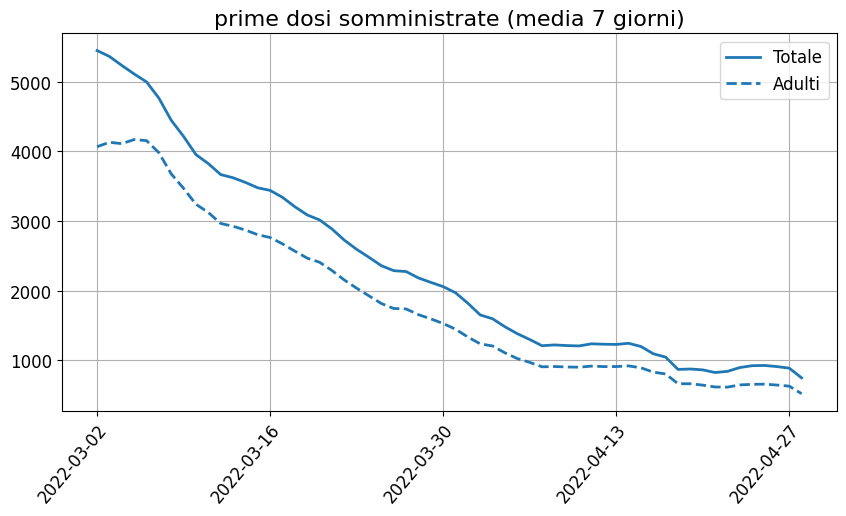

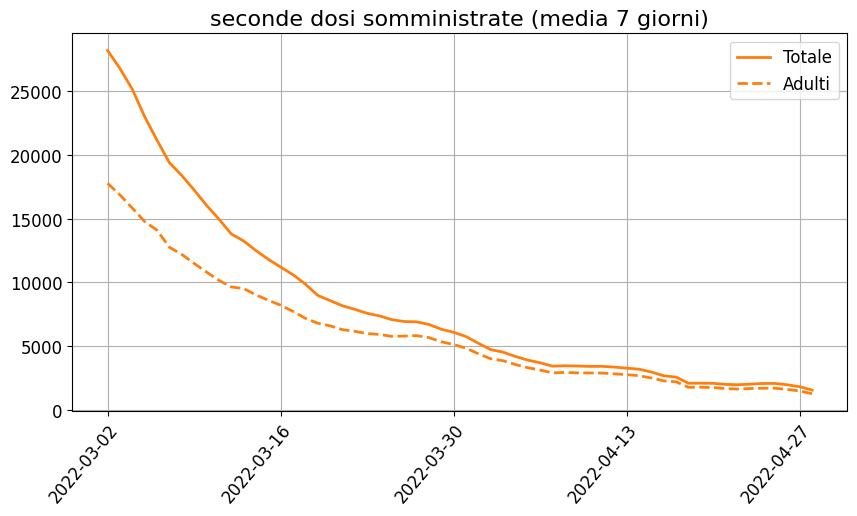

terza


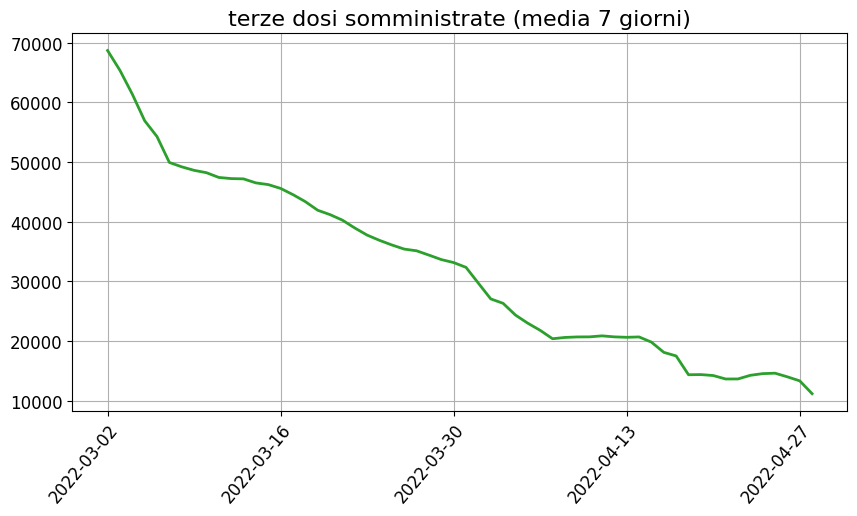

quarta


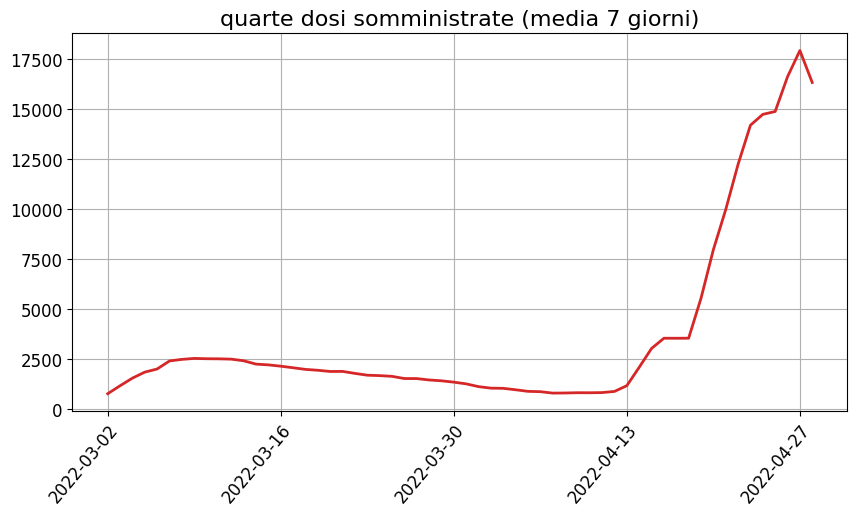

In [76]:
i = 0
for dose in ["prima","seconda","terza","quarta"]:
    y_tot = df_vax_yyyy_mm_dd[f"{dose}_dose_media_7"].dropna()
    y_adu = df_vax_yyyy_mm_dd[f"{dose}_dose_adulti_media_7"].dropna()
        
    if all(y_tot == y_adu):
        print(dose)
        y_vars = [f"{dose}_dose_media_7"]
        labels = None
        linestyles = None
        colors = [COLORS[i]]
    else:
        y_vars = [f"{dose}_dose_media_7", f"{dose}_dose_adulti_media_7"]
        labels = ["Totale", "Adulti"]
        linestyles = ["-", "--"]
        colors = [COLORS[i], COLORS[i]]
        
    createXYPlot(df_vax_yyyy_mm_dd, 
                 y=y_vars,
                 labels=labels,
                 linestyles=linestyles,
                 colors=colors,
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 start_date="2022-03-01",
                 title=f"{dose[:-1]+'e'} dosi somministrate (media 7 giorni)",
                 plots_folder=plots_folder,
                 savename=f"{dose[:-1]+'e'}_dosi_somministrate.png"
                )
    i +=1

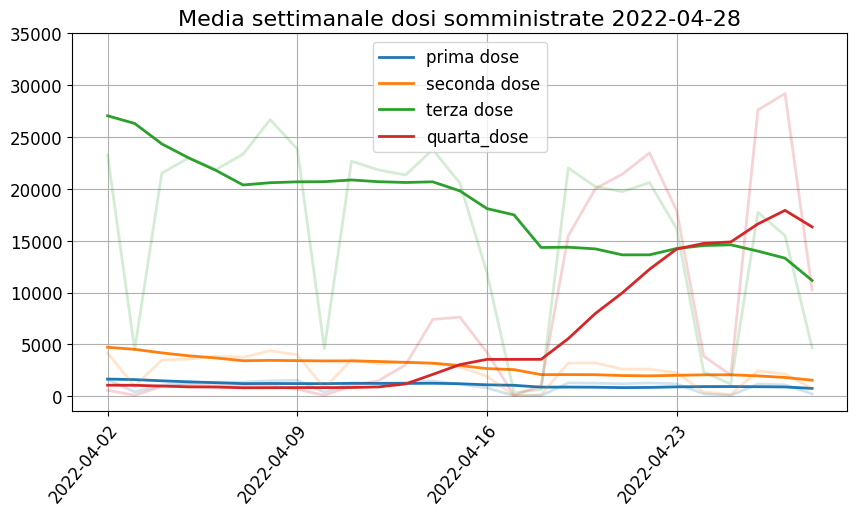

In [75]:
createXYPlot(df_vax_yyyy_mm_dd, 
                 y=["prima_dose",
                    "prima_dose_media_7",
                    "seconda_dose",
                    "seconda_dose_media_7",
                    "terza_dose",
                    "terza_dose_media_7",
                    "quarta_dose",
                    "quarta_dose_media_7"
                   ], 
                 labels=[None,
                         "prima dose",
                         None,
                         "seconda dose",
                         None,
                         "terza dose",
                         None,
                         "quarta_dose"
                        ],
                 alphas=[0.2,1,0.2,1,0.2,1,0.2,1],
                 colors=[COLORS[0],COLORS[0],
                         COLORS[1],COLORS[1],
                         COLORS[2],COLORS[2],
                         COLORS[3],COLORS[3]
                        ],
                 x="data_somministrazione", 
                 days_interval=7,
                 linewidth=2,
                 title=f"Media settimanale dosi somministrate {oggi}",
                 plots_folder=plots_folder,
                 yticks=range(0,40000,5000),
                 start_date="2022-04-01",
                 savename=f"dosi_somministrate_media7")

In [77]:
for c in ["prima", "seconda", "terza", "quarta"]:
    df_vax_yyyy_mm_dd[f"totale_{c}_dose"] = df_vax_yyyy_mm_dd[f"{c}_dose"].cumsum()


df_vax_yyyy_mm_dd["totale_prima_dose_no_guariti"] = df_vax_yyyy_mm_dd["prima_dose_no_guariti"].cumsum()
df_vax_yyyy_mm_dd["totale_pregressa_infezione"] = df_vax_yyyy_mm_dd["pregressa_infezione"].cumsum()

In [78]:
df_vax_yyyy_mm_dd_fornitore["totale_prima_dose"] = df_vax_yyyy_mm_dd_fornitore.groupby("fornitore")["prima_dose"].cumsum()
df_vax_yyyy_mm_dd_fornitore["totale_seconda_dose"] = df_vax_yyyy_mm_dd_fornitore.groupby("fornitore")["seconda_dose"].cumsum()
df_vax_yyyy_mm_dd_fornitore["totale_terza_dose"] = df_vax_yyyy_mm_dd_fornitore.groupby("fornitore")["terza_dose"].cumsum()
df_vax_yyyy_mm_dd_fornitore["totale_quarta_dose"] = df_vax_yyyy_mm_dd_fornitore.groupby("fornitore")["quarta_dose"].cumsum()


In [79]:
df_vax_yyyy_mm_dd[["data_somministrazione","prima_dose","prima_dose_media_7","seconda_dose_media_7", "terza_dose_media_7","quarta_dose_media_7"]].tail(10)

,data_somministrazione,prima_dose,prima_dose_media_7,seconda_dose_media_7,terza_dose_media_7,quarta_dose_media_7
478,2022-04-19,1282,876.714286,2082.571429,14371.000000,5548.714286
479,2022-04-20,1252,864.428571,2071.000000,14210.428571,7975.285714
480,2022-04-21,1201,826.285714,1989.571429,13631.285714,9979.000000
481,2022-04-22,1277,843.000000,1960.285714,13637.571429,12242.857143
482,2022-04-23,1185,897.714286,2009.571429,14246.142857,14195.714286
483,2022-04-24,225,924.285714,2059.428571,14529.285714,14737.142857
484,2022-04-25,71,927.571429,2062.571429,14603.285714,14880.857143
485,2022-04-26,1171,911.714286,1956.285714,13990.857143,16615.857143
486,2022-04-27,1092,888.857143,1804.857143,13316.571429,17926.714286
487,2022-04-28,227,749.714286,1539.428571,11163.000000,16330.000000


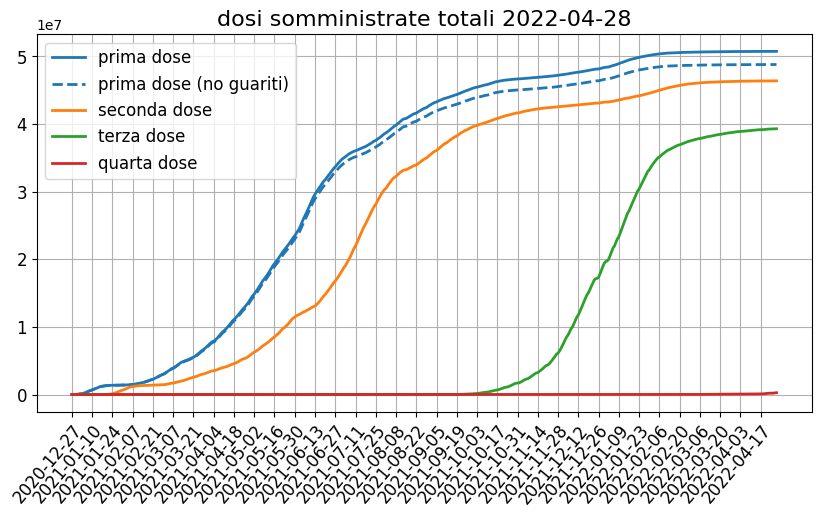

In [81]:
createXYPlot(df_vax_yyyy_mm_dd, 
             y=["totale_prima_dose",
                "totale_prima_dose_no_guariti",
                "totale_seconda_dose",
                "totale_terza_dose", 
                "totale_quarta_dose"
               ], 
             labels=["prima dose", 
                     "prima dose (no guariti)",
                     "seconda dose", 
                     "terza dose", 
                     "quarta dose"
                    ],
             linestyles=["-","--","-","-","-"],
             colors=[COLORS[0],COLORS[0],COLORS[1],COLORS[2],COLORS[3]],
             x="data_somministrazione", 
             days_interval=14,
             linewidth=2,
             title=f"dosi somministrate totali {oggi}",
             plots_folder=plots_folder,
             savename=f"dosi_somministrate_cumulativo.png"
            )

### Cumulativa per fornitore

In [ ]:
for fornitore in fornitori:
    df_plot = df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore==fornitore]
    savename_suffix="_"+fornitore.replace("/","_")    
    createXYPlot(df_plot, 
                 y=["totale_prima_dose","totale_seconda_dose","totale_terza_dose"],
                 labels=["prime dosi","seconde dosi", "terze dosi"],
                 x="data_somministrazione", 
                 days_interval=14,
                 linewidth=2,
                 title=f"dosi somministrate totali {fornitore} {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate_totali_{savename_suffix}.png")

In [ ]:
df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag["fascia_anagrafica"]=="05-11"].tail(3)

In [ ]:
for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
    savename_suffix="_" + anag  
    df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
    df_plot = df_plot.sort_values(by="data_somministrazione")
    createXYPlot(df_plot, 
                 y=["prima_dose", "prima_dose_media_7", "seconda_dose", "seconda_dose_media_7"], 
                 labels=[None, "prima dose", None, "seconda dose"],
                 colors=["b","b","r","r"],
                 alphas=[0.2,1,0.2,1],
                 x="data_somministrazione", 
                 linewidth=2,
                 days_interval=7,
                 start_date="2021-12-01",
                 title=f"dosi somministrate età: {anag}, data: {oggi}",
                 plots_folder=plots_folder,
                 savename=f"dosi_somministrate{savename_suffix}.png")


In [ ]:
grid = get_grid(keys=["data_somministrazione","fascia_anagrafica"])

In [ ]:
df_vax_yyyy_mm_dd_anag = grid.merge(df_vax_yyyy_mm_dd_anag, on=["data_somministrazione","fascia_anagrafica"], how="left")
df_vax_yyyy_mm_dd_anag = df_vax_yyyy_mm_dd_anag.fillna(0)

In [ ]:
def dosi_eta(media=True, 
             start_date="2021-10-01",
             days_interval=7
            ):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for dose in ["prima","seconda","terza"]:
        plt.figure(dpi=100,figsize=(11,5))
        col_idx = 0
        for anag in sorted(df_vax_yyyy_mm_dd_anag["fascia_anagrafica"].unique()):
            df_plot = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica==anag]
            df_plot = df_plot[df_plot.data_somministrazione>=start_date]
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % days_interval == 0]
            if media:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=0.2, color=colors[col_idx])
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose_media_7"], label=anag, color=colors[col_idx], linewidth=2.0)
            else:
                plt.plot(df_plot["data_somministrazione"], df_plot[f"{dose}_dose"], alpha=1, label=anag, color=colors[col_idx])

            col_idx +=1
        plt.xticks(x, rotation=60, 
                   rotation_mode="anchor", 
                   verticalalignment = "top", 
                   horizontalalignment = "right",
                   fontsize=12
                  )
        plt.yticks(fontsize=12)
        #plt.yscale("log")
        plt.legend()
        if dose == "prima":
            title = "Prime dosi"
        elif dose == "seconda":
            title = "Seconde dosi"
        else:
            title = "Terze dosi"
        plt.title(f"{title} somministrate per fascia d'età",fontsize=16)
        savename=f"{plots_folder}/{dose}_dose_fascia_eta"
        if media:
            savename += "_media"
        plt.savefig(fname=f"{savename}.png",bbox_inches="tight")

In [ ]:
dosi_eta(media=True, start_date="2021-10-01", days_interval=14)

In [ ]:
grid = get_grid(keys=["data_somministrazione", "fascia_anagrafica","fornitore"])

In [ ]:
df_vax_yyyy_mm_dd_anag_fornitore = grid.merge(df_vax_yyyy_mm_dd_anag_fornitore, on=["data_somministrazione", "fascia_anagrafica","fornitore"],how="left")
df_vax_yyyy_mm_dd_anag_fornitore = df_vax_yyyy_mm_dd_anag_fornitore.fillna(0)

In [ ]:
df_vax_yyyy_mm_dd_anag_fornitore[df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica=="05-11"]

In [ ]:
def plot_anag_fornitore(start_date, media=False):
    for dose in ["prima","seconda","terza"]:
        for fornitore in fornitori:
            plt.figure(dpi=100, figsize=(10,4))
            max_val_0 = 0
            col_idx = 0
            for anag in anagrafiche:
                condizione = (df_vax_yyyy_mm_dd_anag_fornitore.fornitore == fornitore) & (df_vax_yyyy_mm_dd_anag_fornitore.fascia_anagrafica==anag)
                df_plot = df_vax_yyyy_mm_dd_anag_fornitore[condizione]
                df_plot = df_plot[df_plot.data_somministrazione>=start_date]
                Xval = df_plot["data_somministrazione"]
                Yval = df_plot[f"{dose}_dose"]
                Yval_media7 = df_plot[f"{dose}_dose_media_7"]
                if media:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=0.15, color=colors[col_idx])
                    plt.plot(Xval, Yval_media7, label=anag, linewidth=2.0, color=colors[col_idx])
                else:
                    plt.plot(Xval, Yval, linewidth=1.8, alpha=1, color=colors[col_idx],label=anag)
                max_val = np.max(Yval)
                col_idx += 1
                if max_val > max_val_0:
                    max_val_0 = max_val
            x = df_plot["data_somministrazione"].tolist()
            x = [ x[i] for i in range(0,len(x)) if i % 7 == 0]
            plt.xticks(x, rotation=60, 
                       rotation_mode="anchor", 
                       verticalalignment = "top", 
                       horizontalalignment = "right",
                       fontsize=12
                      )
            plt.yticks(fontsize=12)
            plt.grid()
            plt.legend()
            if dose == "prima":
                title = "Prime dosi"
            elif dose == "seconda":
                title = "Seconde dosi"
            else:
                title = "Terze dosi"
            title = f"{title} somministrate per fascia d'età"
            if media:
                title += ", media 7 giorni, "
            title += f" {fornitore}"
            savename = f"{plots_folder}/{dose}_dose_{fornitore.replace('/','_')}_eta"
            if media:
                savename += "_media7"
            savename += ".png"
            plt.title(title, fontsize=16)
            plt.savefig(fname=savename,bbox_inches="tight")

In [ ]:
plot_anag_fornitore(start_date="2021-10-01", media=True)

In [ ]:
popolazione = pd.read_csv("https://raw.githubusercontent.com/italia/covid19-opendata-vaccini/master/dati/platea.csv")
popolazione = popolazione.groupby("fascia_anagrafica").sum().reset_index()

In [ ]:
np.sum(popolazione["totale_popolazione"])

In [ ]:
pop_over_50 = popolazione[popolazione.fascia_anagrafica.isin(["50-59","60-69","70-79","80+"])]
display(pop_over_50)
np.sum(pop_over_50["totale_popolazione"])

In [ ]:
prime_dosi_over_50 = df_vax_yyyy_mm_dd_anag[df_vax_yyyy_mm_dd_anag.fascia_anagrafica.isin(["50-59","60-69","70-79","80-89","90+"])][["data_somministrazione","fascia_anagrafica","prima_dose"]]
np.sum(prime_dosi_over_50["prima_dose"])

In [ ]:
df_vax_yyyy_mm_dd_fornitore[df_vax_yyyy_mm_dd_fornitore.fornitore=="Janssen"]

In [ ]:
display(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione=="2021-08-05"][["data_somministrazione","totale_seconda_dose","totale_pregressa_infezione"]])
display(df_vax_yyyy_mm_dd_fornitore[(df_vax_yyyy_mm_dd_fornitore.data_somministrazione=="2021-08-05") & (df_vax_yyyy_mm_dd_fornitore.fornitore=="Janssen")][["data_somministrazione","fornitore","totale_prima_dose"]])
display(df_vax_yyyy_mm_dd[df_vax_yyyy_mm_dd.data_somministrazione=="2021-08-05"][["data_somministrazione","totale_seconda_dose"]])

In [ ]:
from datetime import datetime, timedelta
datetime.strftime(datetime.strptime("2022-02-01","%Y-%m-%d") - timedelta(180),"%Y-%m-%d")

In [ ]:
1061638+1381975+31700161

In [ ]:
df_vax_yyyy_mm_dd[["data_somministrazione","totale_terza_dose"]].tail(10)

In [ ]:
34143774 - 32910171

In [ ]:
df_vax_yyyy_mm_dd["booster_eligibility"] = df_vax_yyyy_mm_dd["data_somministrazione"].apply(lambda x: datetime.strptime(x,"%Y-%m-%d") + timedelta(120)) 